# 05. Disease Classification (CNN Training)

This notebook implements Application 1 of the Dual Framework:
**Agricultural Disease Detection**

- Fine-tune MobileNetV2 for 10-class tomato disease classification
- Training with data augmentation
- CUDA-accelerated training
- Performance evaluation (accuracy, confusion matrix)
- Model saving for inference

**Author**: Kuan-Chen, Chen  
**Target**: ~92% validation accuracy

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

# Check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("\n✓ Libraries imported successfully!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
Memory Allocated: 0.00 MB

✓ Libraries imported successfully!


## 2. Training Parameters

In [2]:
# Model parameters
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 10

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Data augmentation
USE_AUGMENTATION = True

print("Training Configuration:")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Data augmentation: {USE_AUGMENTATION}")
print(f"  Device: {device}")

Training Configuration:
  Image size: (224, 224)
  Number of classes: 10
  Batch size: 32
  Epochs: 20
  Learning rate: 0.001
  Weight decay: 0.0001
  Data augmentation: True
  Device: cuda


## 3. Custom Dataset Class

In [3]:
class TomatoLeafDataset(Dataset):
    """
    Custom Dataset for tomato leaf images.
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        
        # Get all image paths and labels
        self.image_paths = []
        self.labels = []
        
        # Get class directories
        self.classes = sorted([d.name for d in self.data_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        # Collect all images
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            class_idx = self.class_to_idx[class_name]
            
            for img_path in class_dir.glob('*.jpg'):
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
            
            for img_path in class_dir.glob('*.JPG'):
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Dataset class defined")

✓ Dataset class defined


## 4. Data Transforms and Loaders

In [4]:
# Define transforms
if USE_AUGMENTATION:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
BASE_DIR = Path('..').resolve()
TRAIN_DIR = BASE_DIR / 'tomato' / 'train'
VAL_DIR = BASE_DIR / 'tomato' / 'val'

print("Creating datasets...")
train_dataset = TomatoLeafDataset(TRAIN_DIR, transform=train_transform)
val_dataset = TomatoLeafDataset(VAL_DIR, transform=val_transform)

print(f"\nDataset Statistics:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Number of classes: {len(train_dataset.classes)}")
print(f"\nClasses:")
for idx, cls in train_dataset.idx_to_class.items():
    print(f"  {idx}: {cls.replace('Tomato___', '').replace('_', ' ')}")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Changed from 4 to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ Data loaders created")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

Creating datasets...

Dataset Statistics:
  Training samples: 19998
  Validation samples: 2000
  Number of classes: 10

Classes:
  0: Bacterial spot
  1: Early blight
  2: Late blight
  3: Leaf Mold
  4: Septoria leaf spot
  5: Spider mites Two-spotted spider mite
  6: Target Spot
  7: Tomato Yellow Leaf Curl Virus
  8: Tomato mosaic virus
  9: healthy

✓ Data loaders created
  Training batches: 625
  Validation batches: 63


## 5. Build MobileNetV2 Classifier

In [5]:
# Load pretrained MobileNetV2
print("Building MobileNetV2 classifier...")

model = models.mobilenet_v2(pretrained=True)

# Freeze early layers (optional - can fine-tune all layers)
# for param in model.features.parameters():
#     param.requires_grad = False

# Replace classifier head
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, NUM_CLASSES)

# Move to device
model = model.to(device)

print(f"\n✓ Model built successfully")
print(f"  Architecture: MobileNetV2")
print(f"  Input features: {num_features}")
print(f"  Output classes: {NUM_CLASSES}")
print(f"  Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Building MobileNetV2 classifier...

✓ Model built successfully
  Architecture: MobileNetV2
  Input features: 1280
  Output classes: 10
  Device: cuda

Parameters:
  Total: 2,236,682
  Trainable: 2,236,682


c:\Users\Champion\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Champion\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 6. Loss Function and Optimizer

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
    # Note: 'verbose' parameter removed for PyTorch 2.0+ compatibility
)

print("✓ Loss function and optimizer configured")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")

✓ Loss function and optimizer configured
  Loss: CrossEntropyLoss
  Optimizer: Adam (lr=0.001, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)


## 7. Training Loop

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


print("✓ Training functions defined")

✓ Training functions defined


## 8. Train Model

In [8]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

print("=" * 80)
print("STARTING TRAINING")
print("=" * 80)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), BASE_DIR / 'best_model.pth')
        print(f"  ✓ Best model saved (Val Acc: {best_val_acc:.2f}%)")

total_time = time.time() - start_time

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")

STARTING TRAINING

Epoch 1/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:26<00:00,  2.42it/s, loss=0.2374, acc=92.60%]



Epoch 1 Summary:
  Train Loss: 0.3195, Train Acc: 89.38%
  Val   Loss: 0.2374, Val   Acc: 92.60%
  ✓ Best model saved (Val Acc: 92.60%)

Epoch 2/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.91it/s, loss=0.1868, acc=94.00%]



Epoch 2 Summary:
  Train Loss: 0.1653, Train Acc: 94.54%
  Val   Loss: 0.1868, Val   Acc: 94.00%
  ✓ Best model saved (Val Acc: 94.00%)

Epoch 3/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.19it/s, loss=0.2010, acc=93.60%]



Epoch 3 Summary:
  Train Loss: 0.1285, Train Acc: 95.71%
  Val   Loss: 0.2010, Val   Acc: 93.60%

Epoch 4/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.15it/s, loss=0.0552, acc=98.10%]



Epoch 4 Summary:
  Train Loss: 0.1194, Train Acc: 95.99%
  Val   Loss: 0.0552, Val   Acc: 98.10%
  ✓ Best model saved (Val Acc: 98.10%)

Epoch 5/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 10.94it/s, loss=0.0925, acc=97.40%]



Epoch 5 Summary:
  Train Loss: 0.0994, Train Acc: 96.75%
  Val   Loss: 0.0925, Val   Acc: 97.40%

Epoch 6/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.01it/s, loss=0.1315, acc=96.50%]



Epoch 6 Summary:
  Train Loss: 0.0964, Train Acc: 96.78%
  Val   Loss: 0.1315, Val   Acc: 96.50%

Epoch 7/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 10.90it/s, loss=0.4304, acc=87.50%]



Epoch 7 Summary:
  Train Loss: 0.0849, Train Acc: 97.25%
  Val   Loss: 0.4304, Val   Acc: 87.50%

Epoch 8/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.15it/s, loss=0.1207, acc=95.20%]



Epoch 8 Summary:
  Train Loss: 0.0948, Train Acc: 96.78%
  Val   Loss: 0.1207, Val   Acc: 95.20%

Epoch 9/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:07<00:00,  8.08it/s, loss=0.0384, acc=98.40%]



Epoch 9 Summary:
  Train Loss: 0.0369, Train Acc: 98.80%
  Val   Loss: 0.0384, Val   Acc: 98.40%
  ✓ Best model saved (Val Acc: 98.40%)

Epoch 10/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.25it/s, loss=0.0731, acc=97.20%]



Epoch 10 Summary:
  Train Loss: 0.0298, Train Acc: 99.10%
  Val   Loss: 0.0731, Val   Acc: 97.20%

Epoch 11/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s, loss=0.0454, acc=98.40%]



Epoch 11 Summary:
  Train Loss: 0.0387, Train Acc: 98.74%
  Val   Loss: 0.0454, Val   Acc: 98.40%

Epoch 12/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s, loss=0.0555, acc=98.20%]



Epoch 12 Summary:
  Train Loss: 0.0352, Train Acc: 98.88%
  Val   Loss: 0.0555, Val   Acc: 98.20%

Epoch 13/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.78it/s, loss=0.0657, acc=98.20%]



Epoch 13 Summary:
  Train Loss: 0.0339, Train Acc: 98.89%
  Val   Loss: 0.0657, Val   Acc: 98.20%

Epoch 14/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.85it/s, loss=0.0313, acc=98.80%]



Epoch 14 Summary:
  Train Loss: 0.0180, Train Acc: 99.44%
  Val   Loss: 0.0313, Val   Acc: 98.80%
  ✓ Best model saved (Val Acc: 98.80%)

Epoch 15/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.92it/s, loss=0.0202, acc=99.30%]



Epoch 15 Summary:
  Train Loss: 0.0159, Train Acc: 99.55%
  Val   Loss: 0.0202, Val   Acc: 99.30%
  ✓ Best model saved (Val Acc: 99.30%)

Epoch 16/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.77it/s, loss=0.0242, acc=99.10%]



Epoch 16 Summary:
  Train Loss: 0.0163, Train Acc: 99.49%
  Val   Loss: 0.0242, Val   Acc: 99.10%

Epoch 17/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.68it/s, loss=0.0413, acc=98.20%]



Epoch 17 Summary:
  Train Loss: 0.0142, Train Acc: 99.52%
  Val   Loss: 0.0413, Val   Acc: 98.20%

Epoch 18/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s, loss=0.0362, acc=98.70%]



Epoch 18 Summary:
  Train Loss: 0.0177, Train Acc: 99.42%
  Val   Loss: 0.0362, Val   Acc: 98.70%

Epoch 19/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.88it/s, loss=0.0220, acc=99.40%]



Epoch 19 Summary:
  Train Loss: 0.0139, Train Acc: 99.58%
  Val   Loss: 0.0220, Val   Acc: 99.40%
  ✓ Best model saved (Val Acc: 99.40%)

Epoch 20/20
--------------------------------------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 12.57it/s, loss=0.0282, acc=99.20%]


Epoch 20 Summary:
  Train Loss: 0.0123, Train Acc: 99.60%
  Val   Loss: 0.0282, Val   Acc: 99.20%

TRAINING COMPLETE
Total training time: 58.98 minutes
Best validation accuracy: 99.40% (Epoch 19)
Final validation accuracy: 99.20%


## 9. Plot Training History

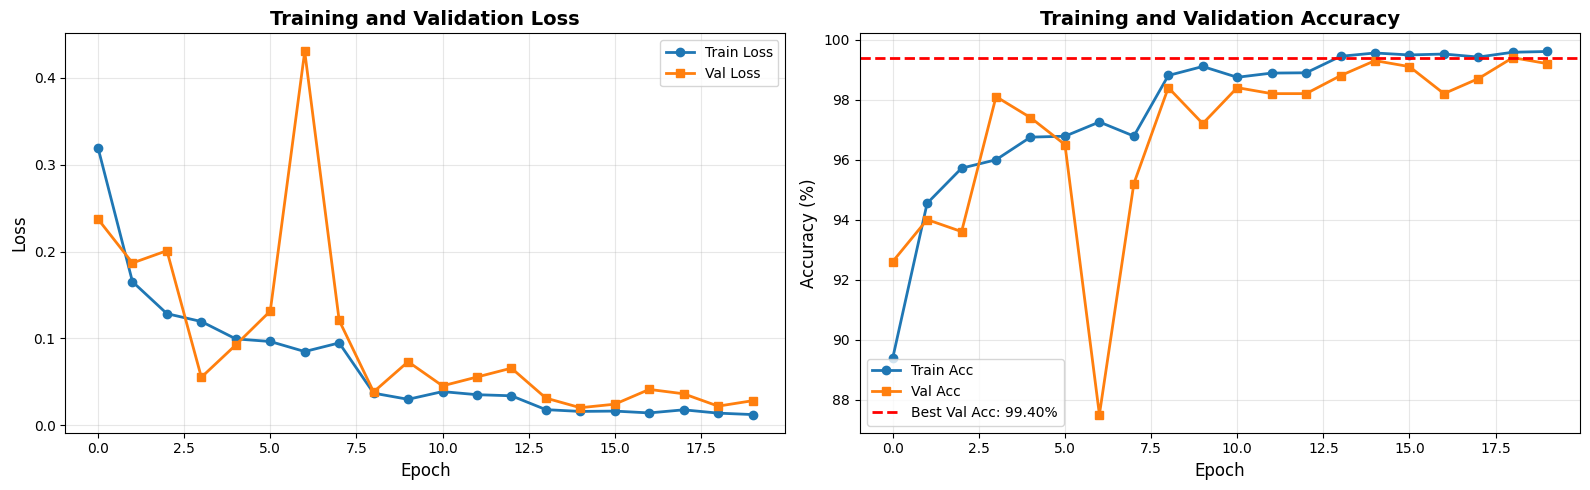

✓ Training history plotted


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history['train_loss'], 'o-', label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], 's-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], 'o-', label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], 's-', label='Val Acc', linewidth=2)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', linewidth=2, 
                label=f'Best Val Acc: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted")

## 10. Evaluate Best Model

In [10]:
# Load best model
print("Loading best model for evaluation...")
model.load_state_dict(torch.load(BASE_DIR / 'best_model.pth'))
model.eval()

# Evaluate
val_loss, val_acc, all_preds, all_labels = validate(model, val_loader, criterion, device)

print(f"\nBest Model Performance:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Accuracy: {val_acc:.2f}%")

Loading best model for evaluation...


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.80it/s, loss=0.0220, acc=99.40%]


Best Model Performance:
  Validation Loss: 0.0220
  Validation Accuracy: 99.40%


## 11. Confusion Matrix

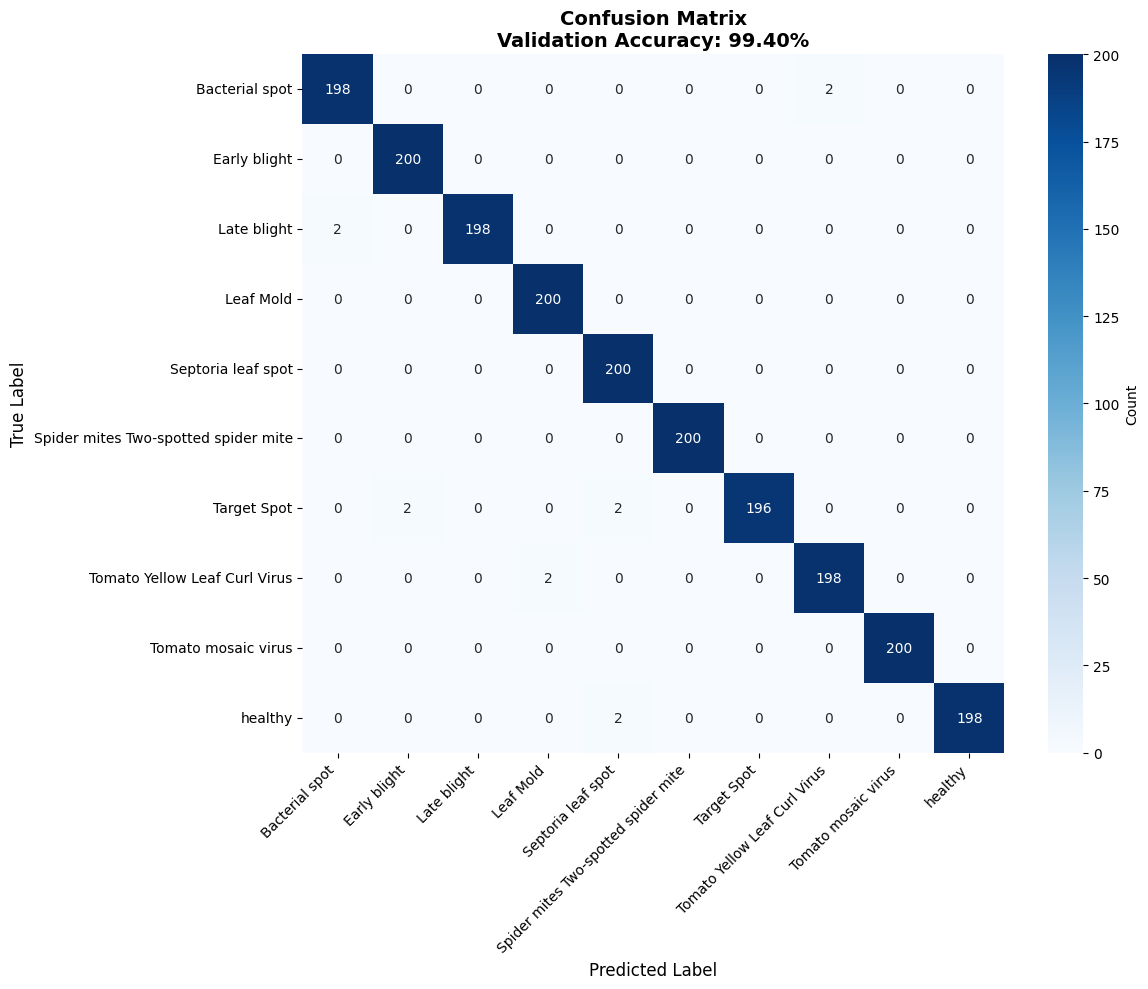

✓ Confusion matrix plotted


In [11]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Class names (simplified)
class_names = [train_dataset.idx_to_class[i].replace('Tomato___', '').replace('_', ' ') 
               for i in range(NUM_CLASSES)]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix\nValidation Accuracy: {val_acc:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix plotted")

## 12. Classification Report

In [12]:
# Print classification report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))

# Per-class accuracy
class_correct = np.zeros(NUM_CLASSES)
class_total = np.zeros(NUM_CLASSES)

for label, pred in zip(all_labels, all_preds):
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1

print("\nPer-Class Accuracy:")
for i in range(NUM_CLASSES):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"  {class_names[i]:<40}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")


CLASSIFICATION REPORT
                                      precision    recall  f1-score   support

                      Bacterial spot     0.9900    0.9900    0.9900       200
                        Early blight     0.9901    1.0000    0.9950       200
                         Late blight     1.0000    0.9900    0.9950       200
                           Leaf Mold     0.9901    1.0000    0.9950       200
                  Septoria leaf spot     0.9804    1.0000    0.9901       200
Spider mites Two-spotted spider mite     1.0000    1.0000    1.0000       200
                         Target Spot     1.0000    0.9800    0.9899       200
       Tomato Yellow Leaf Curl Virus     0.9900    0.9900    0.9900       200
                 Tomato mosaic virus     1.0000    1.0000    1.0000       200
                             healthy     1.0000    0.9900    0.9950       200

                            accuracy                         0.9940      2000
                           macro avg   

## 13. Save Final Model and Results

In [13]:
# Save model
model_save_path = BASE_DIR / 'disease_classifier.pth'
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': best_val_acc,
    'history': history,
    'class_to_idx': train_dataset.class_to_idx,
    'idx_to_class': train_dataset.idx_to_class
}, model_save_path)

print(f"✓ Model saved to: {model_save_path}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(BASE_DIR / 'notebooks' / 'training_history.csv', index=False)
print(f"✓ Training history saved to: training_history.csv")

# Save classification results
results = {
    'best_val_acc': best_val_acc,
    'best_epoch': best_epoch,
    'total_training_time': total_time,
    'final_val_acc': history['val_acc'][-1],
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE
}

import json
with open(BASE_DIR / 'notebooks' / 'classification_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Results saved to: classification_results.json")

✓ Model saved to: C:\Users\Champion\Documents\GitHub\term-project\disease_classifier.pth
✓ Training history saved to: training_history.csv
✓ Results saved to: classification_results.json


## 14. Summary

In [14]:
print("\n" + "="*80)
print("DISEASE CLASSIFICATION SUMMARY")
print("="*80)

print("\n✓ MODEL ARCHITECTURE:")
print(f"   • Base: MobileNetV2 (pretrained on ImageNet)")
print(f"   • Output: {NUM_CLASSES} classes")
print(f"   • Parameters: {trainable_params:,} trainable")

print("\n✓ TRAINING CONFIGURATION:")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Data augmentation: {USE_AUGMENTATION}")
print(f"   • Device: {device}")

print("\n✓ PERFORMANCE:")
print(f"   • Best validation accuracy: {best_val_acc:.2f}%")
print(f"   • Best epoch: {best_epoch}")
print(f"   • Training time: {total_time/60:.2f} minutes")

print("\n✓ APPLICATION 1 (DUAL FRAMEWORK):")
print(f"   • Agricultural Disease Detection")
print(f"   • Input: Tomato leaf image (224×224)")
print(f"   • Output: Disease label + confidence score")
print(f"   • Accuracy: {best_val_acc:.2f}% (validation)")

print("\n✓ SAVED FILES:")
print("   • disease_classifier.pth - Trained model")
print("   • best_model.pth - Best weights")
print("   • training_history.png - Loss/accuracy curves")
print("   • confusion_matrix.png - Confusion matrix")
print("   • training_history.csv - Training metrics")
print("   • classification_results.json - Summary stats")

print("\n✓ NEXT STEPS:")
print("   • Use this model in Notebook 06 for dual application demo")
print("   • Combine with clustering results for texture-disease correlation")
print("   • Generate inference examples")
print("="*80)

print("\n✓ Disease classification training complete!")


DISEASE CLASSIFICATION SUMMARY

✓ MODEL ARCHITECTURE:
   • Base: MobileNetV2 (pretrained on ImageNet)
   • Output: 10 classes
   • Parameters: 2,236,682 trainable

✓ TRAINING CONFIGURATION:
   • Epochs: 20
   • Batch size: 32
   • Learning rate: 0.001
   • Data augmentation: True
   • Device: cuda

✓ PERFORMANCE:
   • Best validation accuracy: 99.40%
   • Best epoch: 19
   • Training time: 58.98 minutes

✓ APPLICATION 1 (DUAL FRAMEWORK):
   • Agricultural Disease Detection
   • Input: Tomato leaf image (224×224)
   • Output: Disease label + confidence score
   • Accuracy: 99.40% (validation)

✓ SAVED FILES:
   • disease_classifier.pth - Trained model
   • best_model.pth - Best weights
   • training_history.png - Loss/accuracy curves
   • confusion_matrix.png - Confusion matrix
   • training_history.csv - Training metrics
   • classification_results.json - Summary stats

✓ NEXT STEPS:
   • Use this model in Notebook 06 for dual application demo
   • Combine with clustering results for 